In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import sys
import os
import pickle
import gc
import random

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from penquins import Kowalski
from IPython.display import display, Math, Latex
from astropy.table import Table
from astropy import table as astro_table

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH
from utils import read_fits_to_pandas, pretty_print
from data import COLUMNS_SDSS, read_sdss, read_single_matches
from light_curves import get_data_stats, get_first_matches, get_filter, average_nights, add_lc_stats, \
                         preprocess_ztf_light_curves, limit_date
from ztf import get_ztf_features
from plotting import plot_light_curve
from ml import get_train_data

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100
sns.set_style('ticks', {'axes.grid': False})
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

/tmp/ipykernel_285078/781861970.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Removing duplicates from SDSS

In [9]:
# Read original SDSS file
file_path = os.path.join(DATA_PATH, 'SDSS/specObj-dr18__DUPLICATES.fits')
sdss_data = Table.read(file_path, format='fits')
print(len(sdss_data))

# Remove duplicates
sdss_data_nodups = astro_table.unique(sdss_data, keys=['PLUG_RA', 'PLUG_DEC'])
len(sdss_data_nodups)

# Write a new file
file_path = os.path.join(DATA_PATH, 'SDSS/specObj-dr18.fits')
sdss_data_nodups.write(file_path)

# Preprocessing ZTF chunks

In [4]:
# Merge chunks into one list
chunk_size = 10000
file_path = os.path.join(DATA_PATH, 'ZTF_x_SDSS/chunks_20230821/specObj-dr18_x_ztf_20230821__{}-{}')
data_ztf = []

i = 0
while os.path.exists(file_path.format(i * chunk_size, (i+1) * chunk_size)):
    with open(file_path.format(i * chunk_size, (i+1) * chunk_size), 'rb') as file:
        data_ztf.extend(pickle.load(file))

    if not i % 100:
        print('{} done'.format(i))
    i += 1

data_ztf = np.array(data_ztf)
print(len(data_ztf))

0 done
100 done
200 done
300 done
400 done


In [11]:
# Read a corresponding SDSS file
data_sdss = read_sdss(dr=18, clean=True)

Original SDSS: 5261255
Cleaning SDSS: 4398710


In [49]:
# Singles
idx_singles = [i for i in range(len(data_ztf)) if (len(data_ztf[i]['id_g']) == 1 and len(data_ztf[i]['id_r']) == 1 and len(data_ztf[i]['mjd_g'][0]) > 0 and len(data_ztf[i]['mjd_r'][0]) > 0)]
len(idx_singles)

760312

In [50]:
data_ztf_singles = dict([(filter, get_filter(data_ztf[idx_singles], filter)) for filter in ['g', 'r']])
data_sdss_singles = data_sdss.loc[idx_singles]

In [51]:
# Get rid of a left over dimension
for filter in ['g', 'r']:
    for i in range(len(data_ztf_singles[filter])):
        for key in ['id', 'mjd', 'mag', 'magerr']:
            data_ztf_singles[filter][i][key] = data_ztf_singles[filter][i][key][0]

In [57]:
# Reduced
data_ztf_reduced = {}
for filter in ['g', 'r']:
    data_ztf_reduced[filter] = [average_nights(lc_dict) for lc_dict in tqdm(data_ztf_singles[filter])]

  0%|          | 0/760312 [00:00<?, ?it/s]

  0%|          | 0/760312 [00:00<?, ?it/s]

In [61]:
# Get at least 20 observations
data_ztf_final = {}
data_sdss_final = {}

for filter in ['g', 'r']:
    n_obs = [len(lc_dict['mjd']) for lc_dict in data_ztf_reduced[filter]]
    idx = np.array(n_obs) > 20
    data_ztf_final[filter] = np.array(data_ztf_reduced[filter])[np.where(idx)]
    data_sdss_final[filter] = data_sdss_singles.loc[idx]

In [80]:
for filter in ['g', 'r']:
    print(len(data_ztf_final[filter]))
    print(data_sdss_final[filter].shape)

483114
(483114, 7)
664676
(664676, 7)


In [62]:
for filter in ['g', 'r']:
    # ZTF
    file_path = os.path.join(DATA_PATH, 'ZTF_x_SDSS/ZTF_20230821/ztf_20230821_x_specObj-dr18__singles__filter_{}__reduced'.format(filter))
    with open(file_path, 'wb') as file:
        pickle.dump(data_ztf_final[filter], file)
    print('Saved to: ' + file_path)

    # SDSS
    file_path = os.path.join(DATA_PATH, 'ZTF_x_SDSS/ZTF_20230821/specObj-dr18_x_ztf_20230821__singles__filter_{}__reduced'.format(filter))
    with open(file_path, 'wb') as file:
        pickle.dump(data_sdss_final[filter], file)
    print('Saved to: ' + file_path)

Saved to: /home/sjnakoneczny/data/ZTF_x_SDSS/ZTF_20230821/ztf_20230821_x_specObj-dr18__singles__filter_g__reduced
Saved to: /home/sjnakoneczny/data/ZTF_x_SDSS/ZTF_20230821/specObj-dr18_x_ztf_20230821__singles__filter_g__reduced
Saved to: /home/sjnakoneczny/data/ZTF_x_SDSS/ZTF_20230821/ztf_20230821_x_specObj-dr18__singles__filter_r__reduced
Saved to: /home/sjnakoneczny/data/ZTF_x_SDSS/ZTF_20230821/specObj-dr18_x_ztf_20230821__singles__filter_r__reduced


# Preprocessing ZTF fields

In [16]:
# Make a 1% subsample of the inference data
p_data = 0.01

In [17]:
fields = [296, 297, 423, 424, 487, 488, 562, 563, 682, 683, 699, 700, 717, 718, 777, 778, 841, 842, 852, 853]

inference_data = {'g': [], 'r': []}
for filter in ['g']:
    for field in tqdm(fields):
        with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20240117/fields/ZTF_20240117__field_{}__{}-band'.format(field, filter)), 'rb') as file:
            data = pickle.load(file)
            n_obj = len(data)
            data = [data[i] for i in sorted(random.sample(range(n_obj), int(n_obj * 0.01)))]
            inference_data[filter].extend(data)
            gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
# Save the random subsets
for filter in ['g']:
    with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20240117/ZTF_20240117__test_fields_{}p__{}-band'.format(p_data * 100, filter)), 'wb') as file:
        pickle.dump(inference_data[filter], file)

In [19]:
# Load the random subsets
inference_data = {}
for filter in ['g']:
    with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20240117/ZTF_20240117__test_fields_{}p__{}-band'.format(p_data * 100, filter)), 'rb') as file:
        inference_data[filter] = pickle.load(file)

In [21]:
# Remove deep drilling and get n_obs > 20
for filter in ['g']:
    inference_data[filter] = preprocess_ztf_light_curves(inference_data[filter])

Original data size: 359353


  0%|          | 0/359353 [00:00<?, ?it/s]

Removing deep drilling at n_obs > 20: 204807 (56.99%)
Number of observations higher than 20: 204291 (56.85%)


In [22]:
# Save reduced
for filter in ['g']:
    with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20230821__test_fields_1p__{}-band__reduced'.format(filter)), 'wb') as file:
        pickle.dump(inference_data[filter], file)

# Paper plots

In [25]:
# Get the training data
ztf_x_sdss_lc, sdss_x_ztf = {}, {}
for filter in ['g']:
    ztf_x_sdss_lc[filter], sdss_x_ztf[filter] = \
        get_train_data(ztf_date='20230821', filter=filter, data_subsets=None, return_features=False)

In [41]:
# Load the reduced inference data
inference_data = {}
for filter in ['g']:
    with open(os.path.join(DATA_PATH, 'ZTF/ZTF_20230821__test_fields_1p__{}-band__reduced'.format(filter)), 'rb') as file:
        inference_data[filter] = pickle.load(file)

In [48]:
# Limit the inference date to match the DR16 training data
last_date = 0
for lc_dict in ztf_x_sdss_lc['g']:
    last_date = max(last_date, max(lc_dict['mjd']))
print(last_date)

for filter in ['g']:
    inference_data['g'] = limit_date(inference_data['g'], last_date)

    # Get 20 observations after the date limit
    inference_data[filter] = [lc_dict for lc_dict in tqdm(inference_data[filter]) if len(lc_dict['mjd']) > 20]
    print(len(inference_data[filter]))

60133.4643600001


  0%|          | 0/202646 [00:00<?, ?it/s]

  0%|          | 0/202646 [00:00<?, ?it/s]

202646


In [49]:
# Add the statistics of interest
for filter in ['g']:
    add_lc_stats(inference_data[filter])
    add_lc_stats(ztf_x_sdss_lc[filter])

  0%|          | 0/202646 [00:00<?, ?it/s]

  0%|          | 0/483114 [00:00<?, ?it/s]

In [ ]:
# TODO: Inference test fields

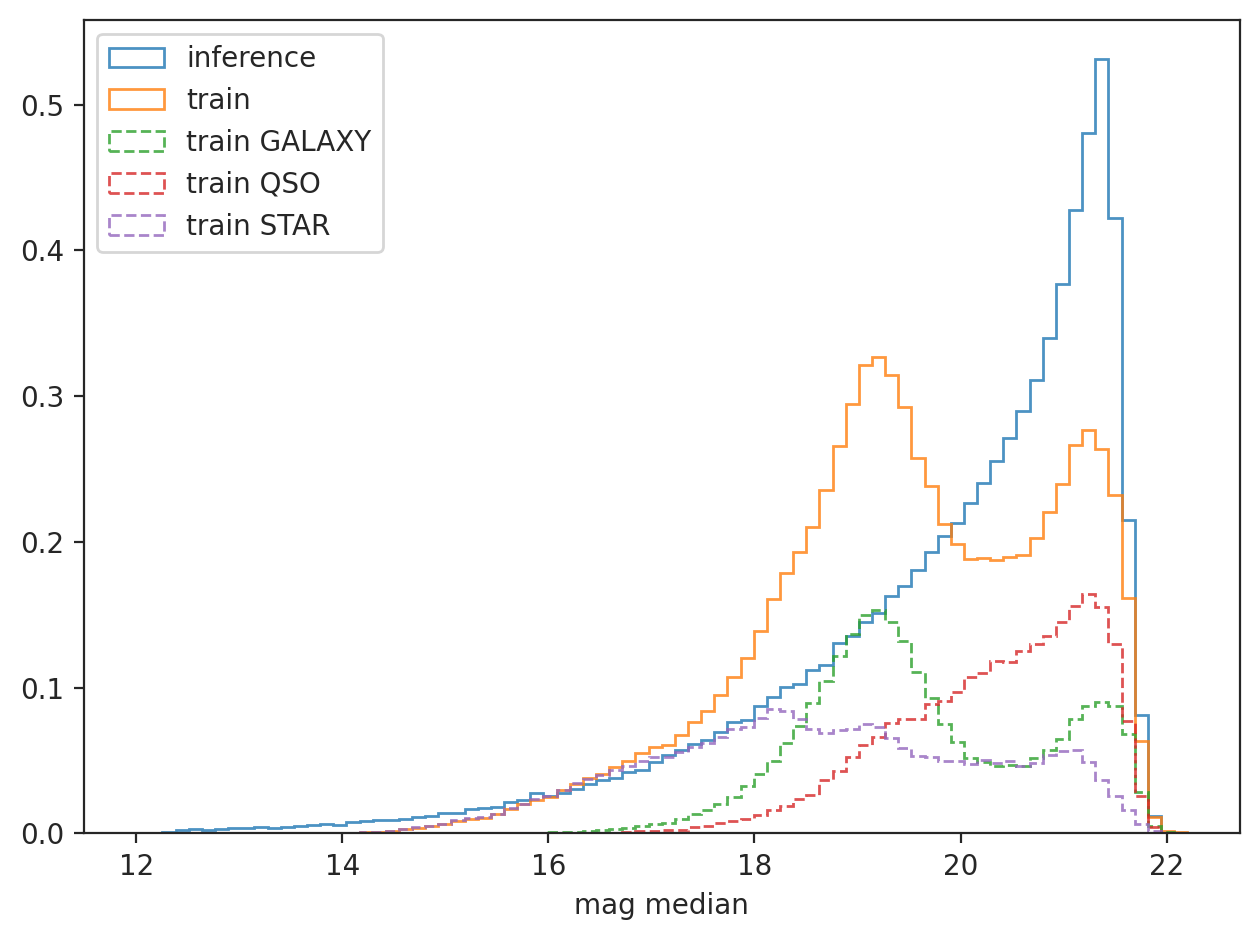

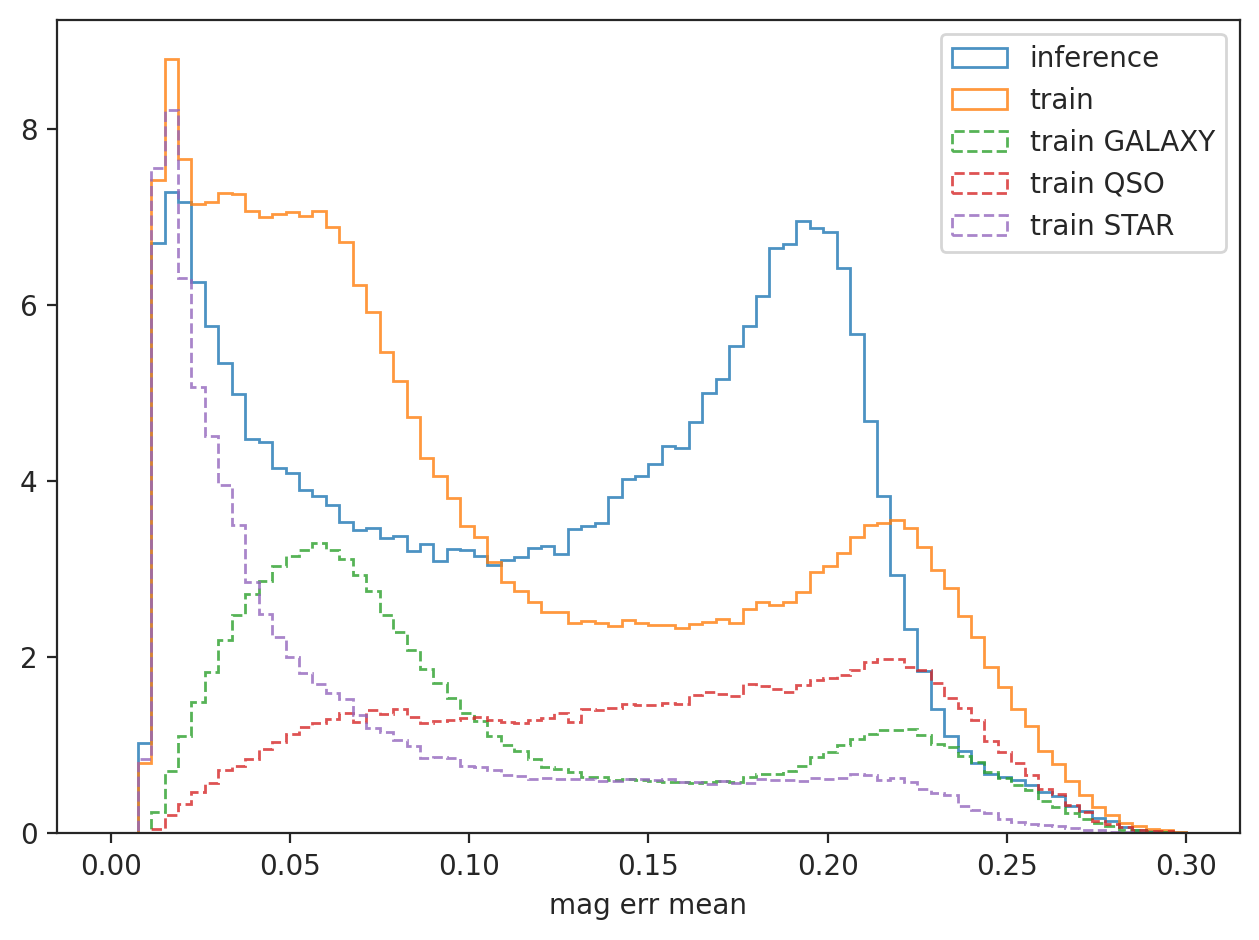

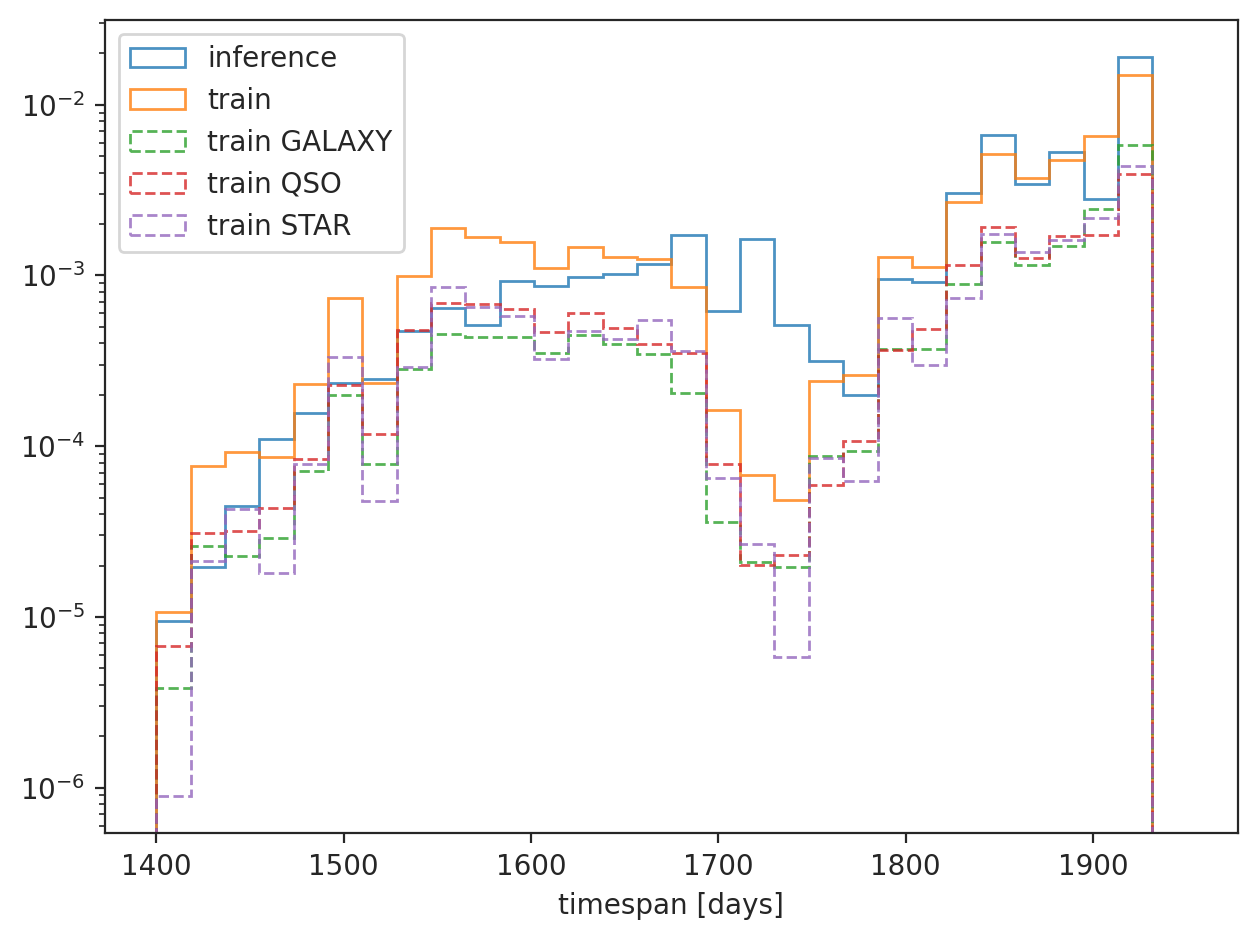

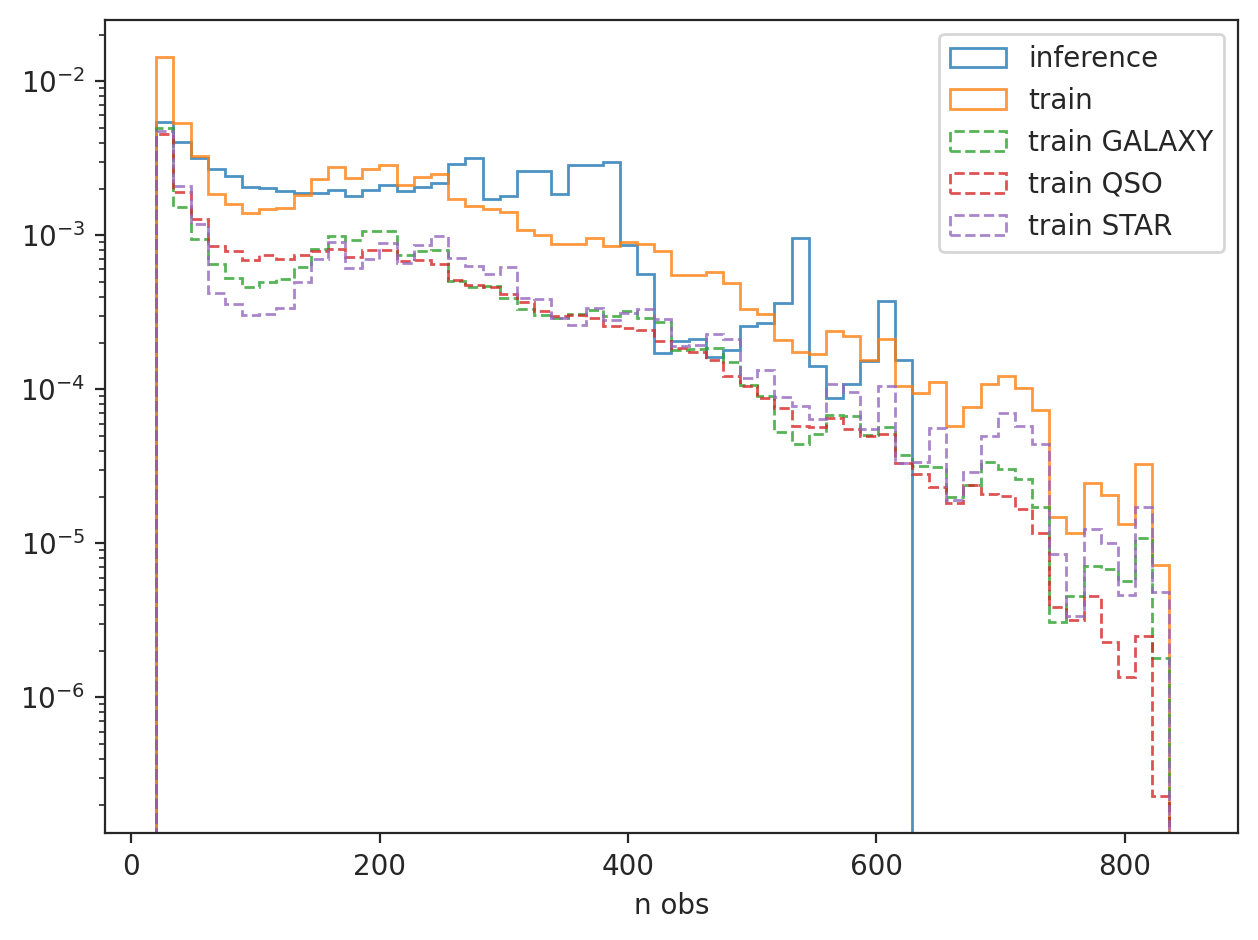

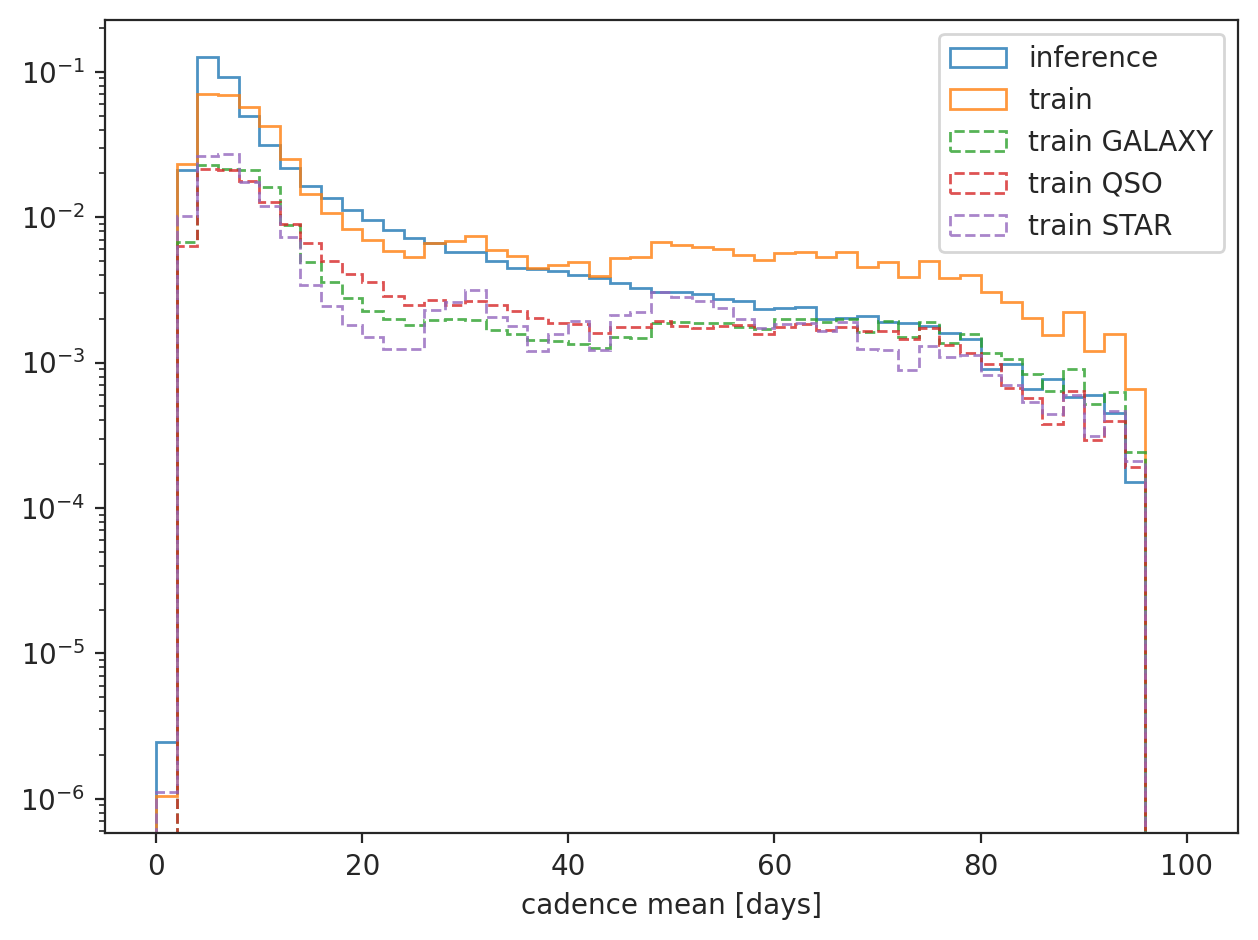

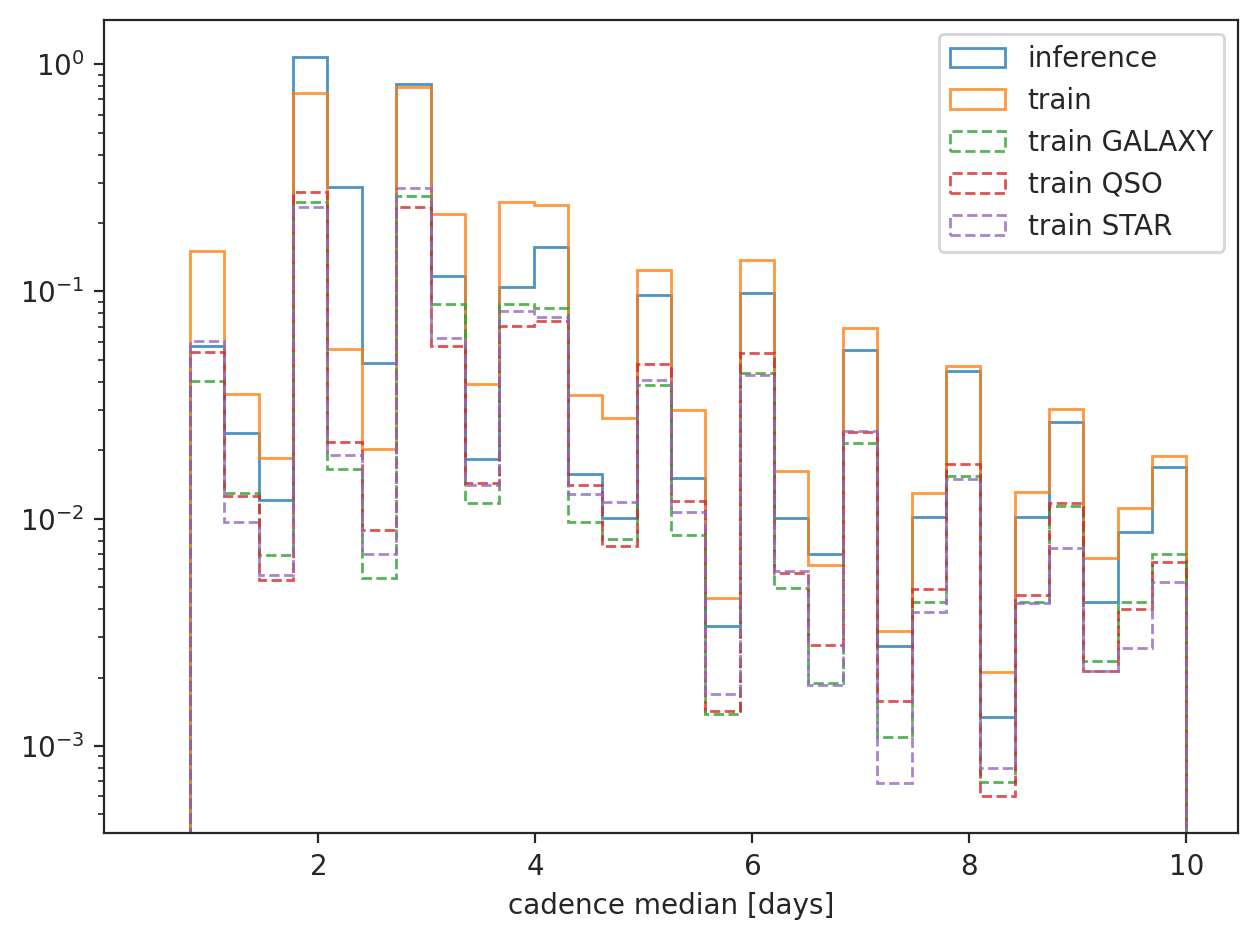

In [51]:
# x label, x range, n bins, log scale
to_plot = [
    ('mag median',      (12, 22.2),    80,  False),
    ('mag err mean',    (0.0, 0.3),    80,  False),
    ('timespan',        (1400, 1950),  30,  True),
    ('n obs',           (20, 850),     60,  True),
    ('cadence mean',    (0, 100),      50,  True),
    ('cadence median',  (0.5, 10),     30,  True),
]

alpha = 0.8

for x, range, n_bins, log_scale in to_plot:    
    for filter in ['g']:
        plt.figure()
        
        # Inference
        vals_inference = [lc.get(x) for lc in inference_data[filter]]
        plt.hist(vals_inference, label='inference', range=range, bins=n_bins, density=True,
                 histtype='step', log=log_scale, alpha=alpha)

        # Train
        vals_train = [lc.get(x) for lc in ztf_x_sdss_lc[filter]]
        plt.hist(vals_train, label='train', range=range, bins=n_bins, density=True,
                 histtype='step', log=log_scale, alpha=alpha)

        # Classes
        for class_name in ['GALAXY', 'QSO', 'STAR']:
            data_cls = ztf_x_sdss_lc[filter][sdss_x_ztf[filter]['CLASS'] == class_name]
            vals_cls = [lc.get(x) for lc in data_cls]
            
            # Make custom histogram to rescale each class by a factor of 1/3
            counts, bins = np.histogram(vals_cls, range=range, bins=n_bins, density=True)
            weights = 1 / 3 * counts
            plt.hist(bins[:-1], bins, weights=weights, label='train ' + class_name,
                     histtype='step', log=log_scale, alpha=alpha, linestyle='--')

        plt.xlabel(pretty_print(x))
        plt.legend()
        plt.tight_layout()
        plt.show()

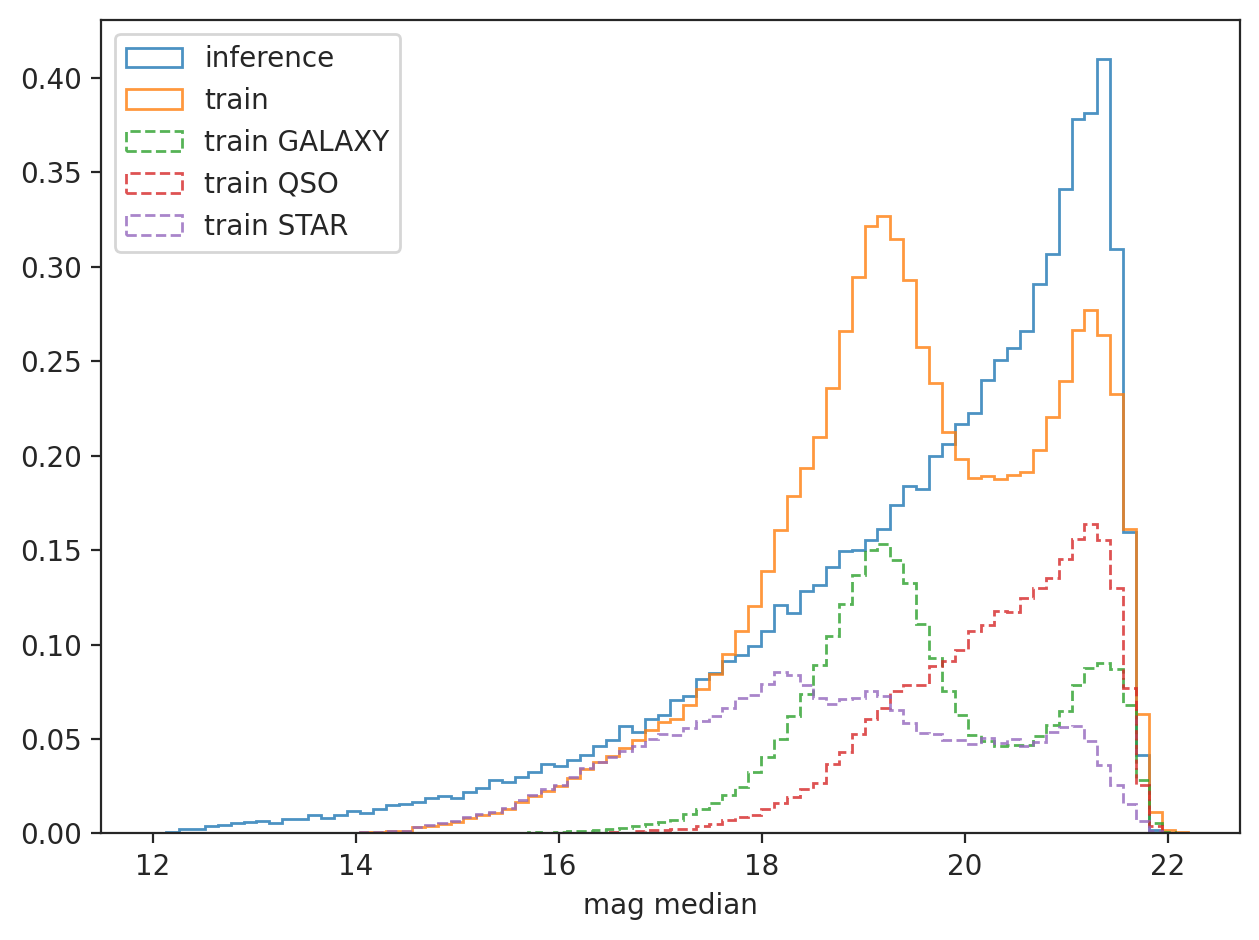

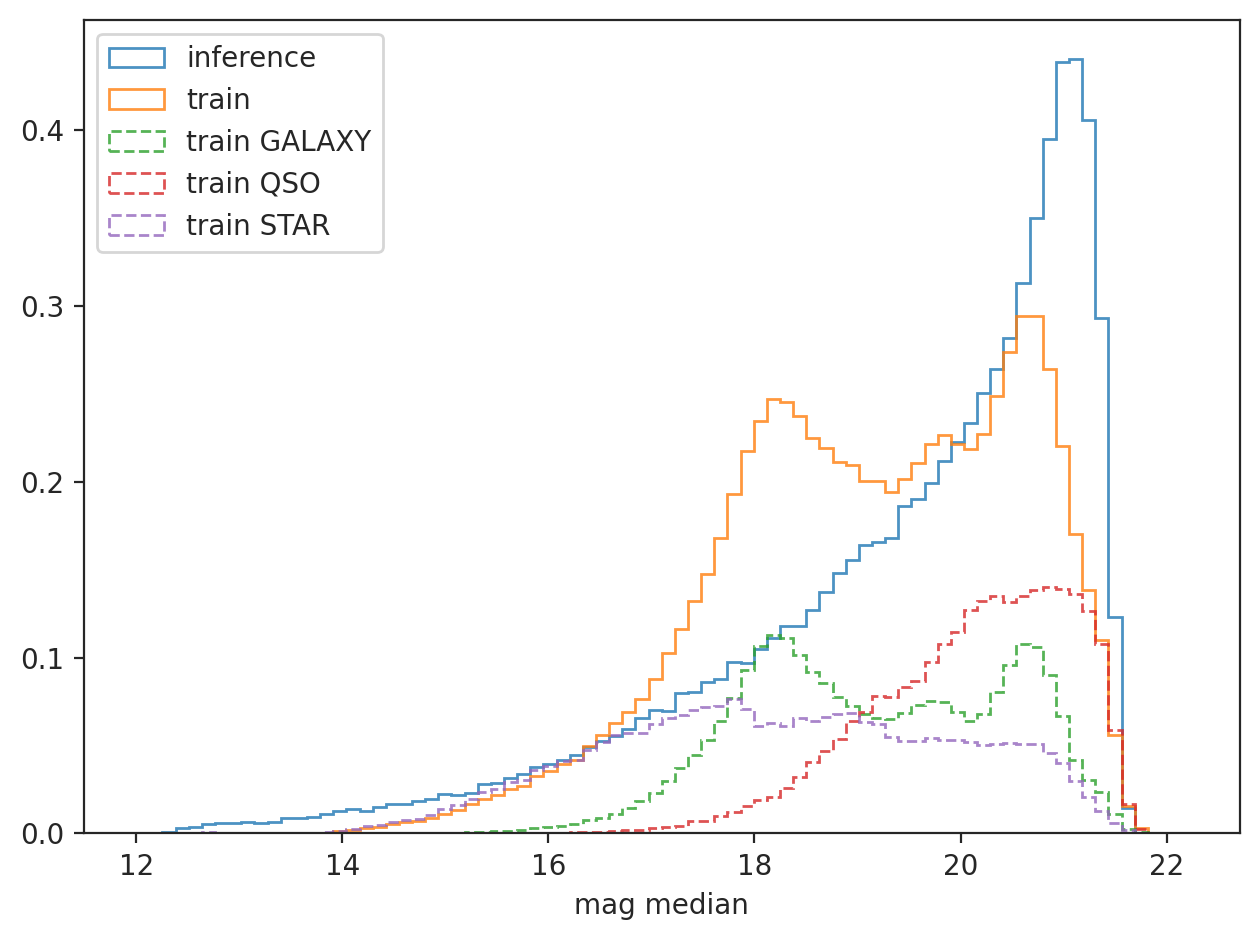

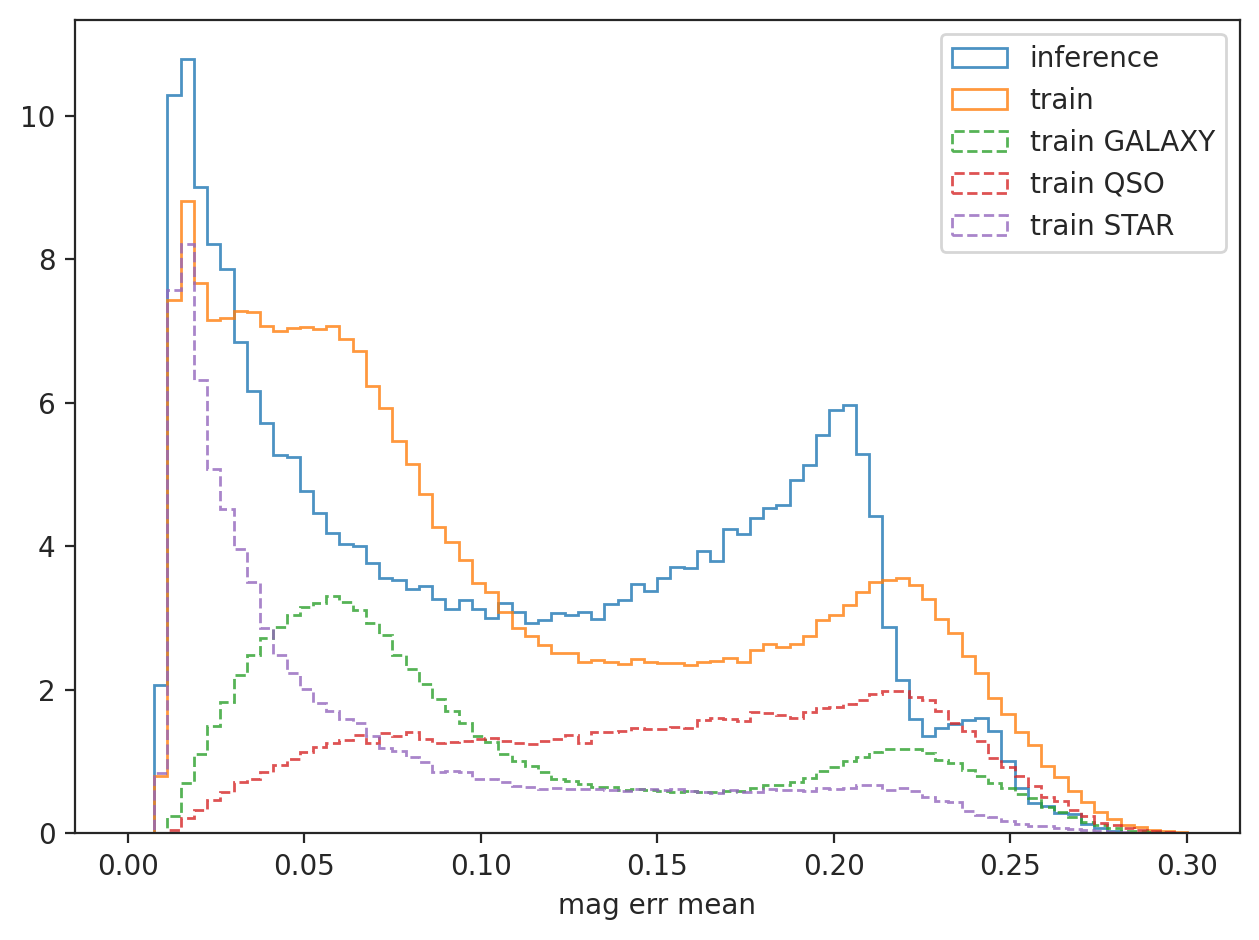

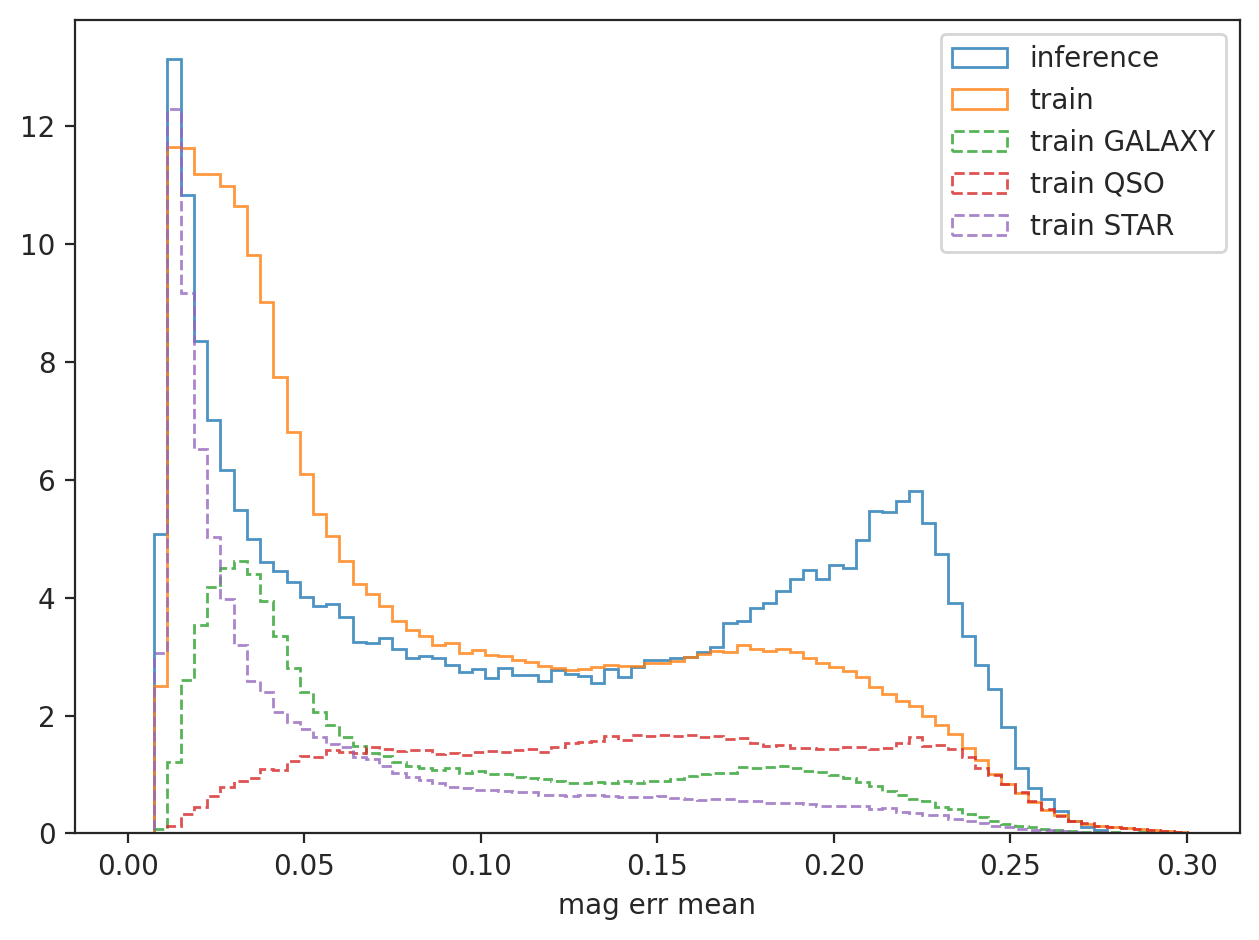

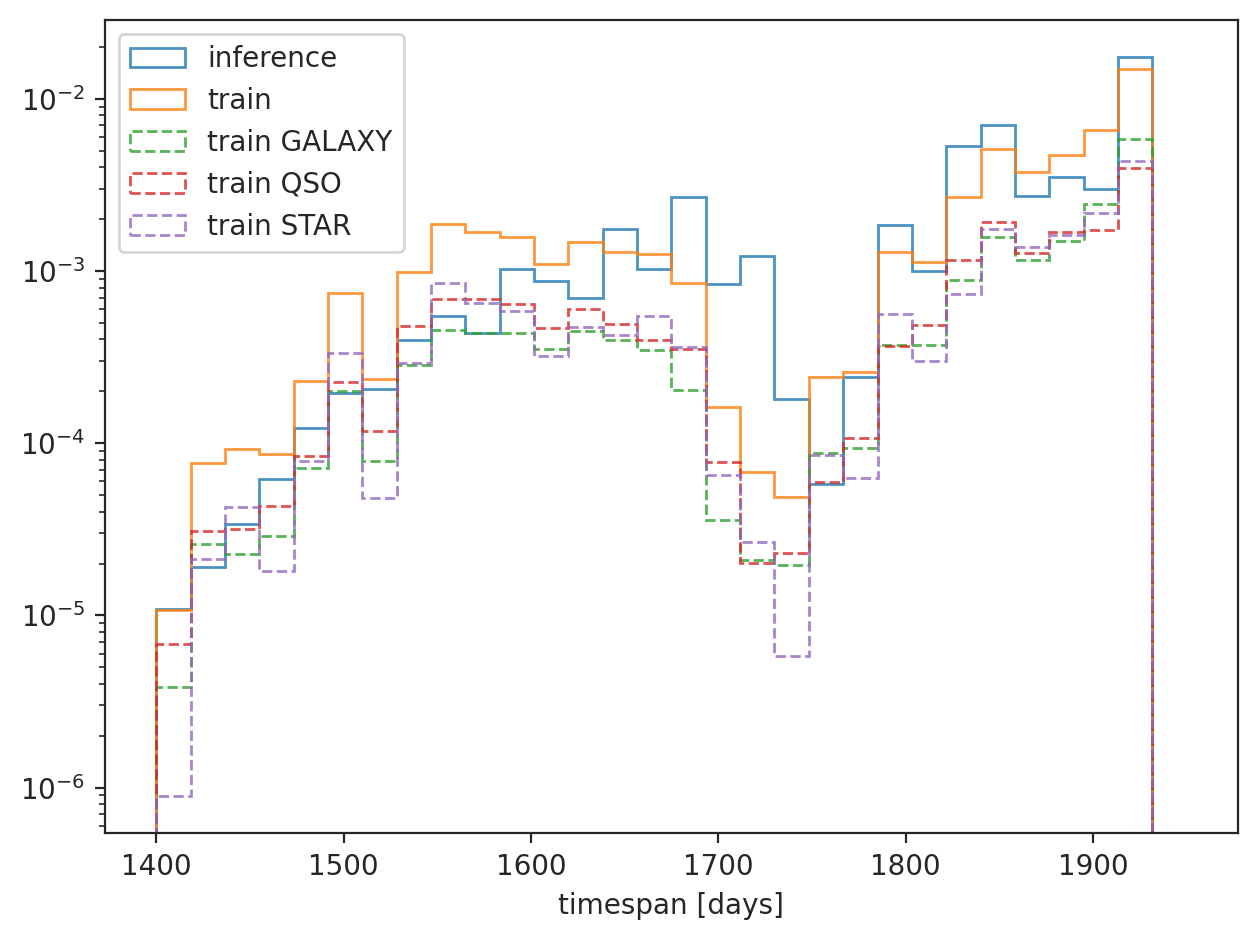

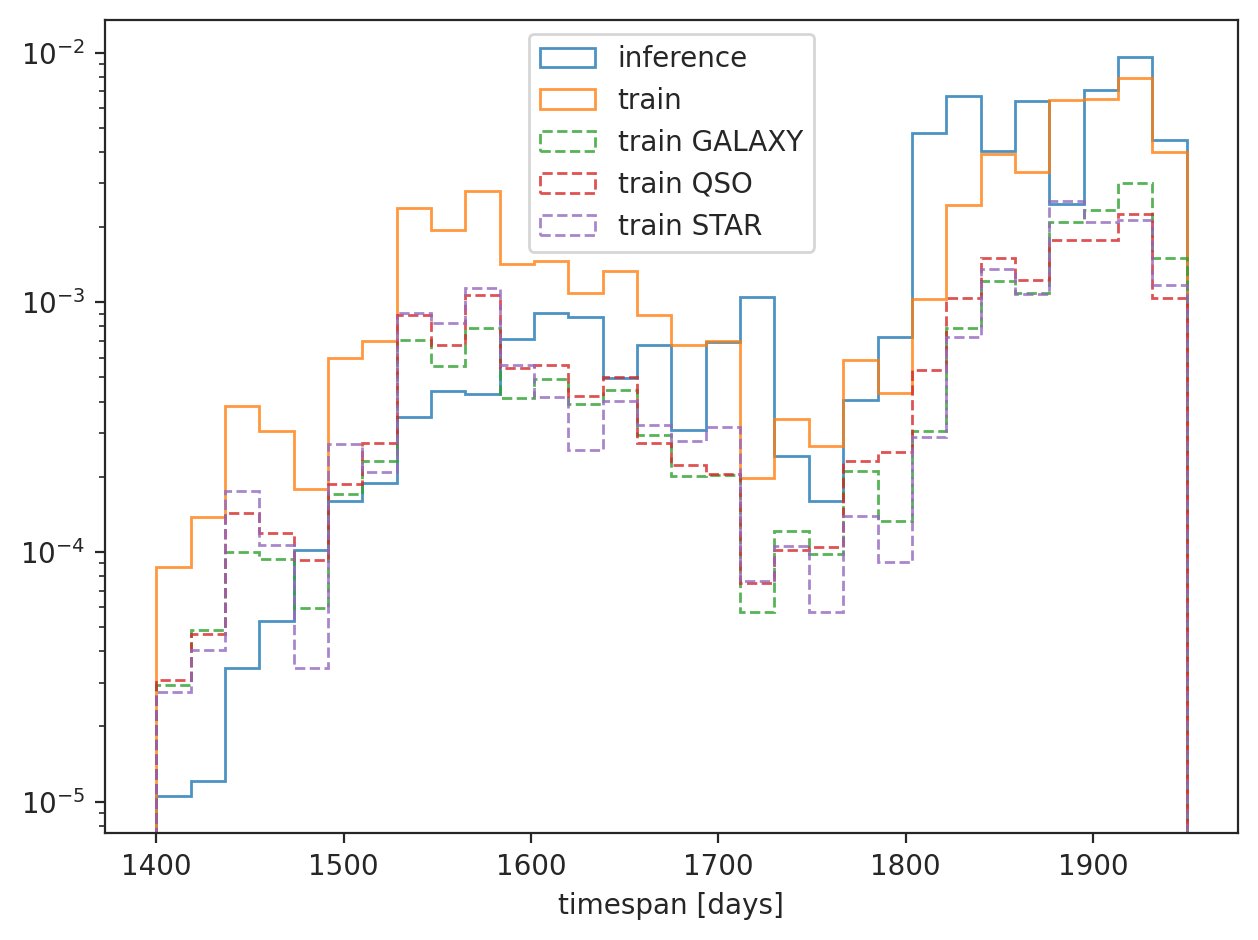

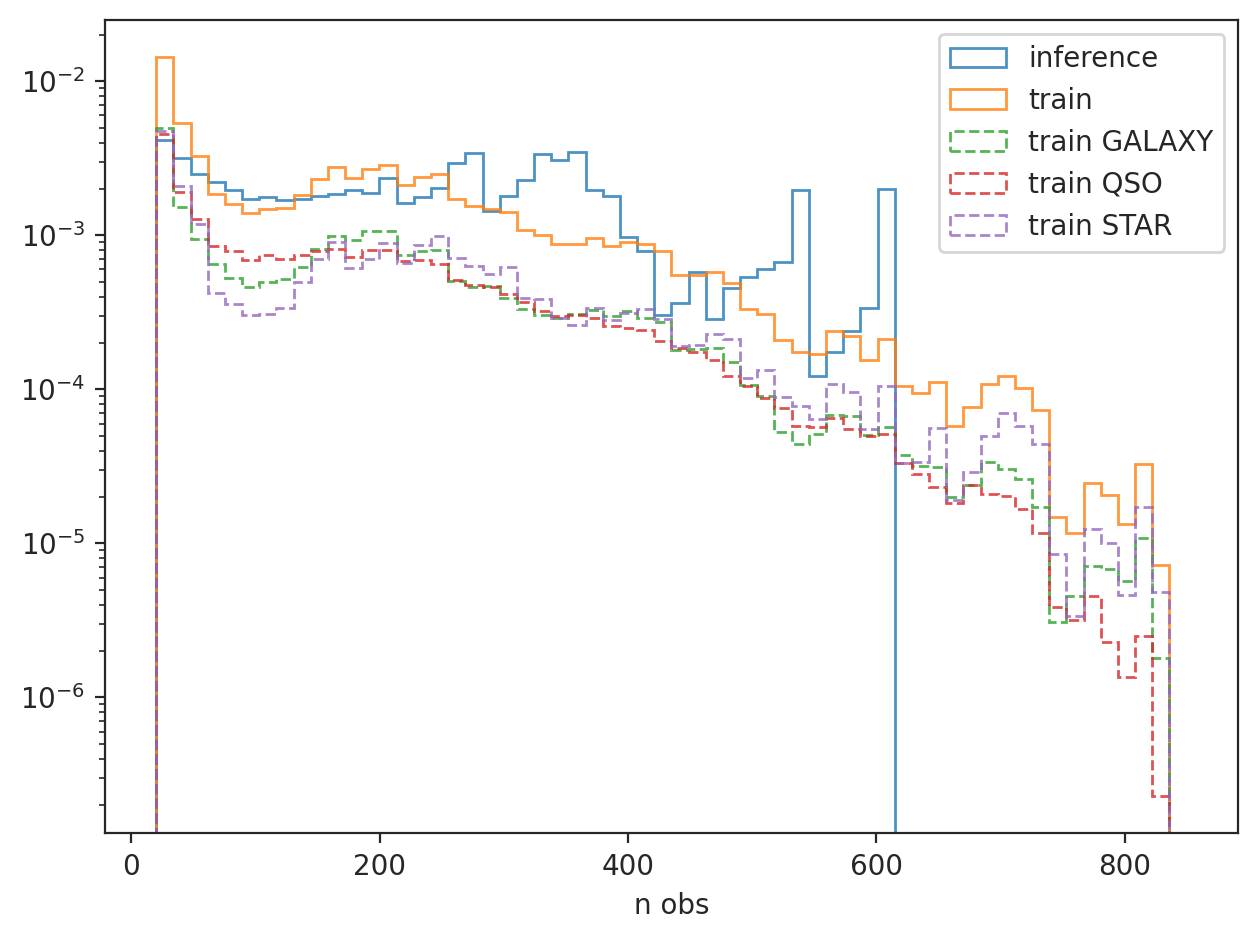

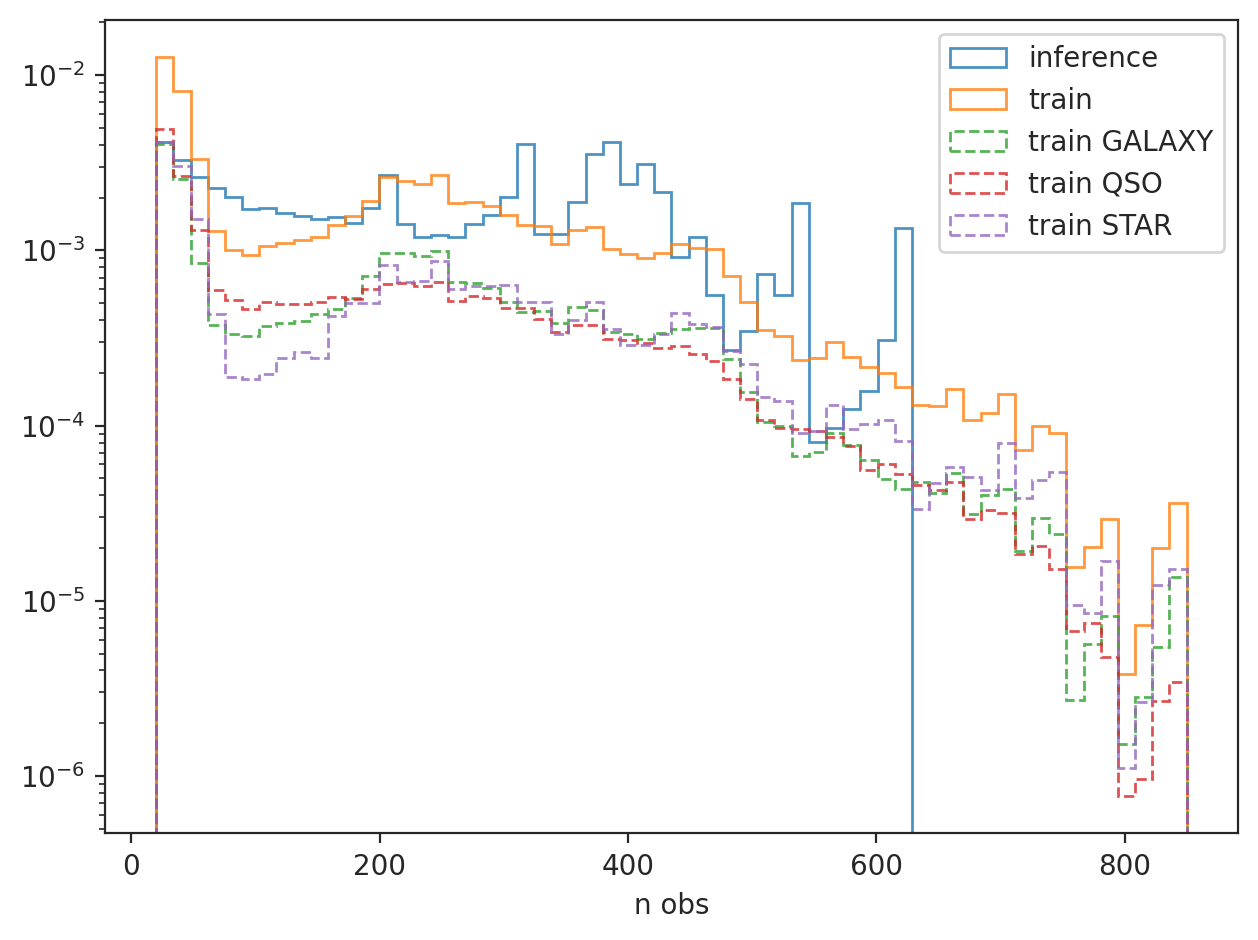

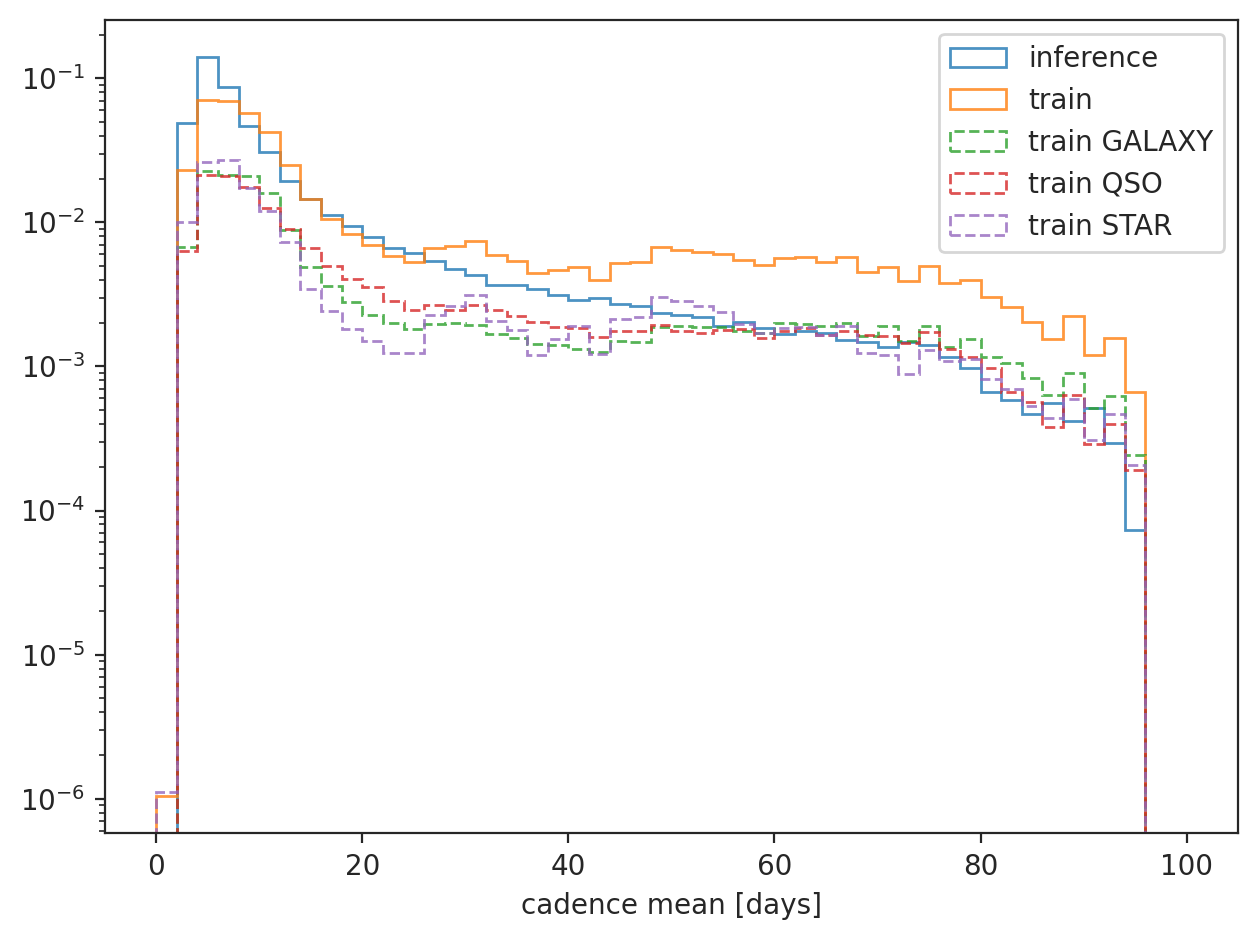

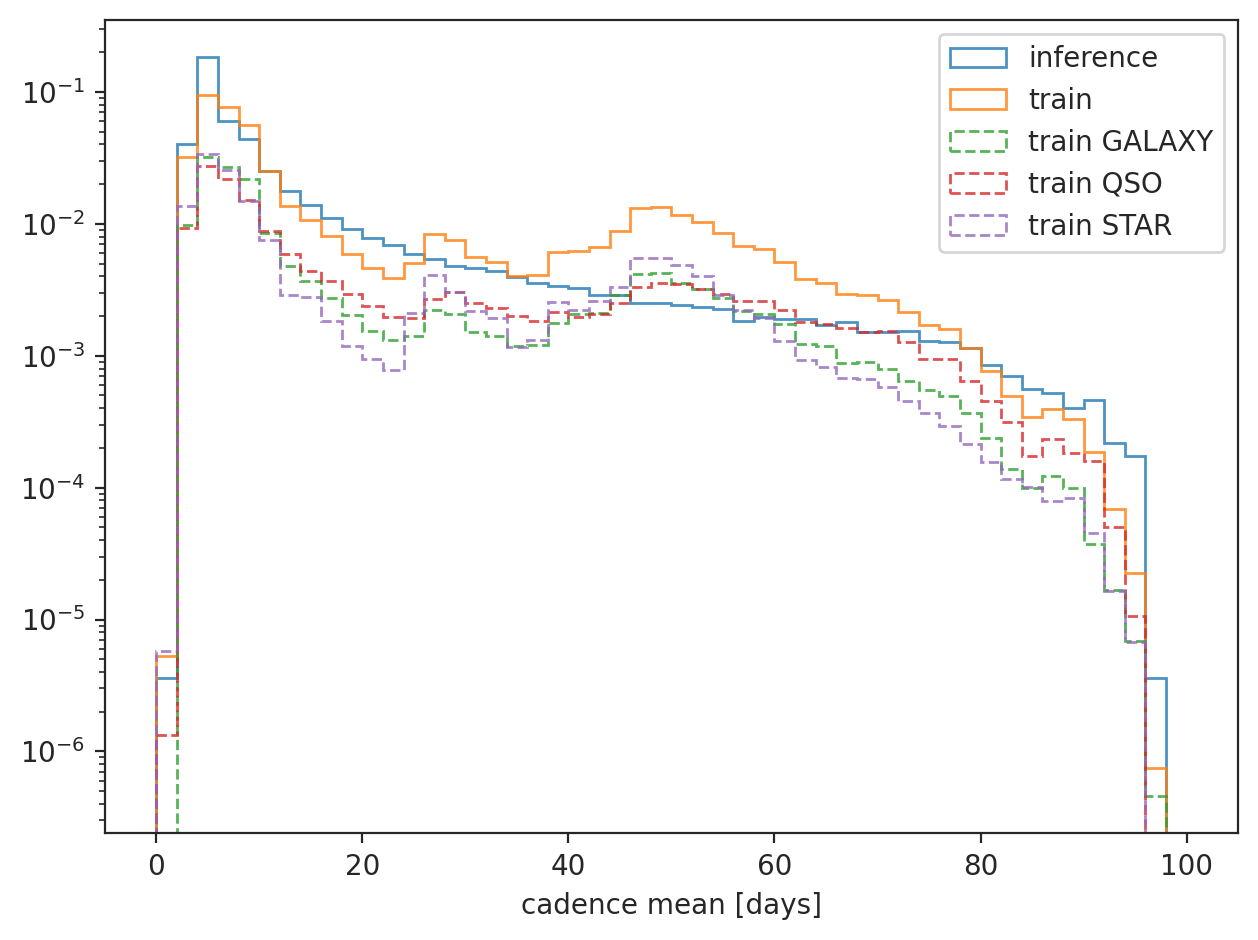

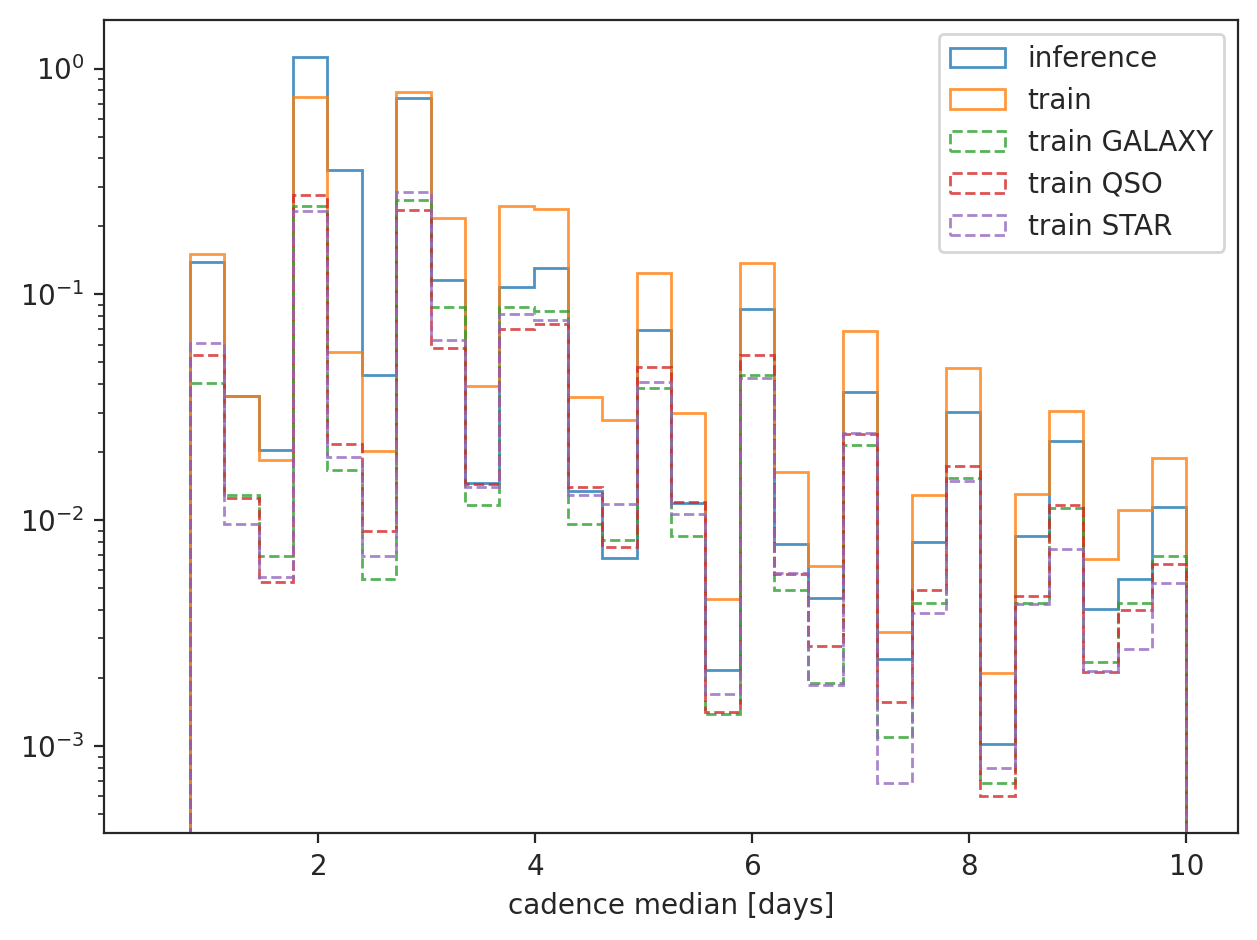

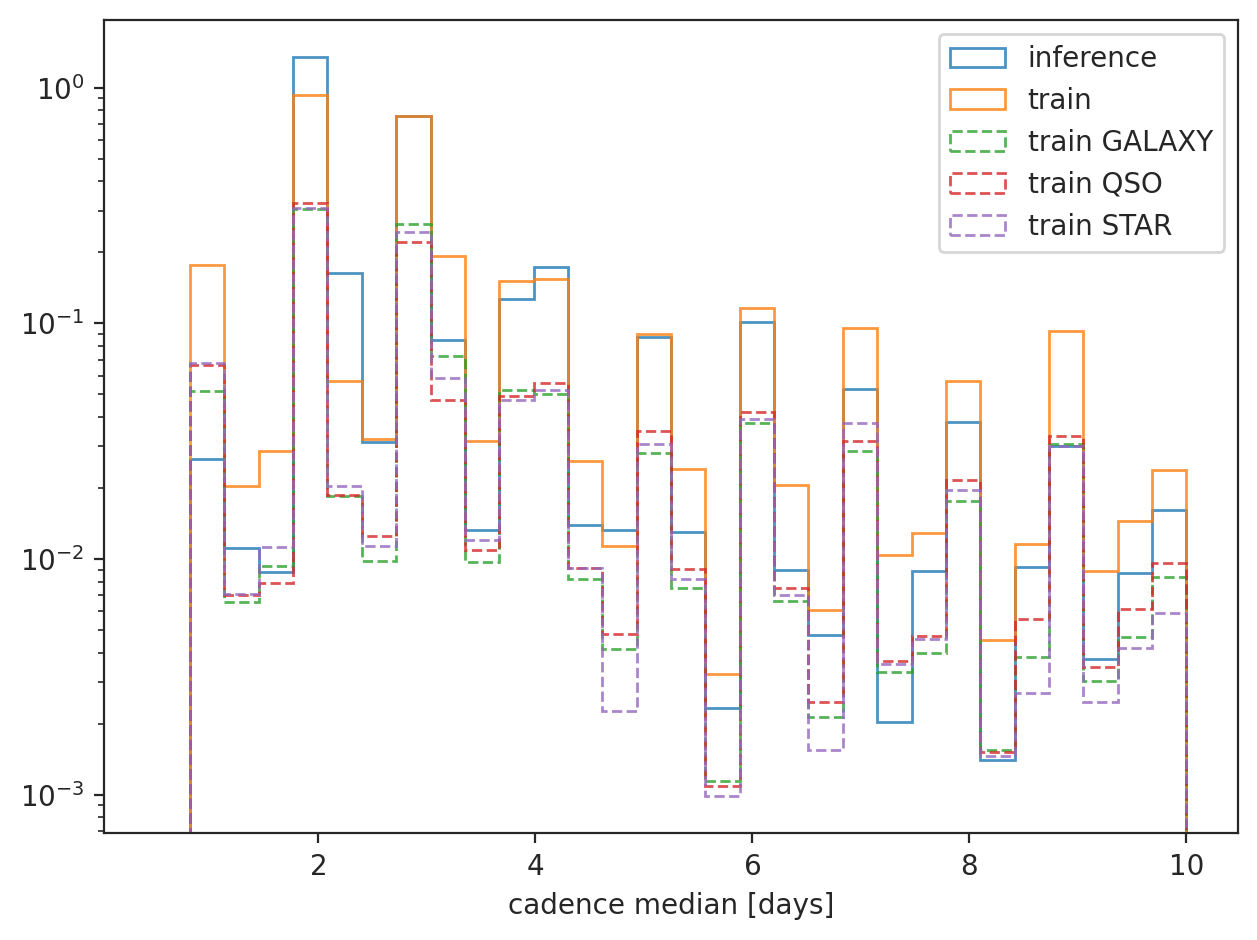

In [112]:
# Old, but with the r-band included
# x label, x range, n bins, log scale
to_plot = [
    ('mag median',      (12, 22.2),    80,  False),
    ('mag err mean',    (0.0, 0.3),    80,  False),
    ('timespan',        (1400, 1950),  30,  True),
    ('n obs',           (20, 850),     60,  True),
    ('cadence mean',    (0, 100),      50,  True),
    ('cadence median',  (0.5, 10),     30,  True),
]

alpha = 0.8

for x, range, n_bins, log_scale in to_plot:    
    for filter in ['g', 'r']:
        plt.figure()
        
        # Inference
        vals_inference = [lc.get(x) for lc in inference_data[filter]]
        plt.hist(vals_inference, label='inference', range=range, bins=n_bins, density=True,
                 histtype='step', log=log_scale, alpha=alpha)

        # Train
        vals_train = [lc.get(x) for lc in ztf_x_sdss_lc[filter]]
        plt.hist(vals_train, label='train', range=range, bins=n_bins, density=True,
                 histtype='step', log=log_scale, alpha=alpha)

        # Classes
        for class_name in ['GALAXY', 'QSO', 'STAR']:
            data_cls = ztf_x_sdss_lc[filter][sdss_x_ztf[filter]['CLASS'] == class_name]
            vals_cls = [lc.get(x) for lc in data_cls]
            
            # Make custom histogram to rescale each class by a factor of 1/3
            counts, bins = np.histogram(vals_cls, range=range, bins=n_bins, density=True)
            weights = 1 / 3 * counts
            plt.hist(bins[:-1], bins, weights=weights, label='train ' + class_name,
                     histtype='step', log=log_scale, alpha=alpha, linestyle='--')

        plt.xlabel(pretty_print(x))
        plt.legend()
        plt.tight_layout()
        plt.show()

# COPIED

In [5]:
# Placeholder kind of
ztf_x_sdss_features = {
    'g': pd.DataFrame(),
    'r': pd.DataFrame(),
}

In [6]:
# Add lightcurve related information to the dataframes
for filter in ['g', 'r']:
    mjds_all = [lc['mjd'] for lc in ztf_x_sdss_lc[filter]]
    # mjds_200 = [mjd[:200] for mjd in mjds_all]

    for mjds, suffix in [(mjds_all, '')]:  # , (mjds_200, '_200')]:
        ztf_x_sdss_features[filter]['n_obs' + suffix] = [len(mjd) for mjd in mjds]
        ztf_x_sdss_features[filter]['timespan' + suffix] = [mjd[-1] - mjd[0] for mjd in mjds]

        intervals = []
        for mjd in mjds:
            intervals.append(np.asarray([mjd[i+1] - mjd[i] for i in range(len(mjd) - 1)], dtype='object'))
        ztf_x_sdss_features[filter]['cadence_mean' + suffix] = [np.mean(i) for i in intervals]
        ztf_x_sdss_features[filter]['cadence_std' + suffix] = [np.std(i) for i in intervals]
        
        stats = np.array([np.percentile(i, [16, 50, 84]) for i in tqdm(intervals)])
        ztf_x_sdss_features[filter]['cadence_median' + suffix] = stats[:, 1]
        ztf_x_sdss_features[filter]['cadence_plus_sigma' + suffix] = stats[:, 2]
        ztf_x_sdss_features[filter]['cadence_minus_sigma' + suffix] = stats[:, 0]

  0%|          | 0/483114 [00:00<?, ?it/s]

  0%|          | 0/664676 [00:00<?, ?it/s]

In [7]:
sdss_x_ztf['g'] = sdss_x_ztf['g'].reset_index(drop=True)
sdss_x_ztf['r'] = sdss_x_ztf['r'].reset_index(drop=True)

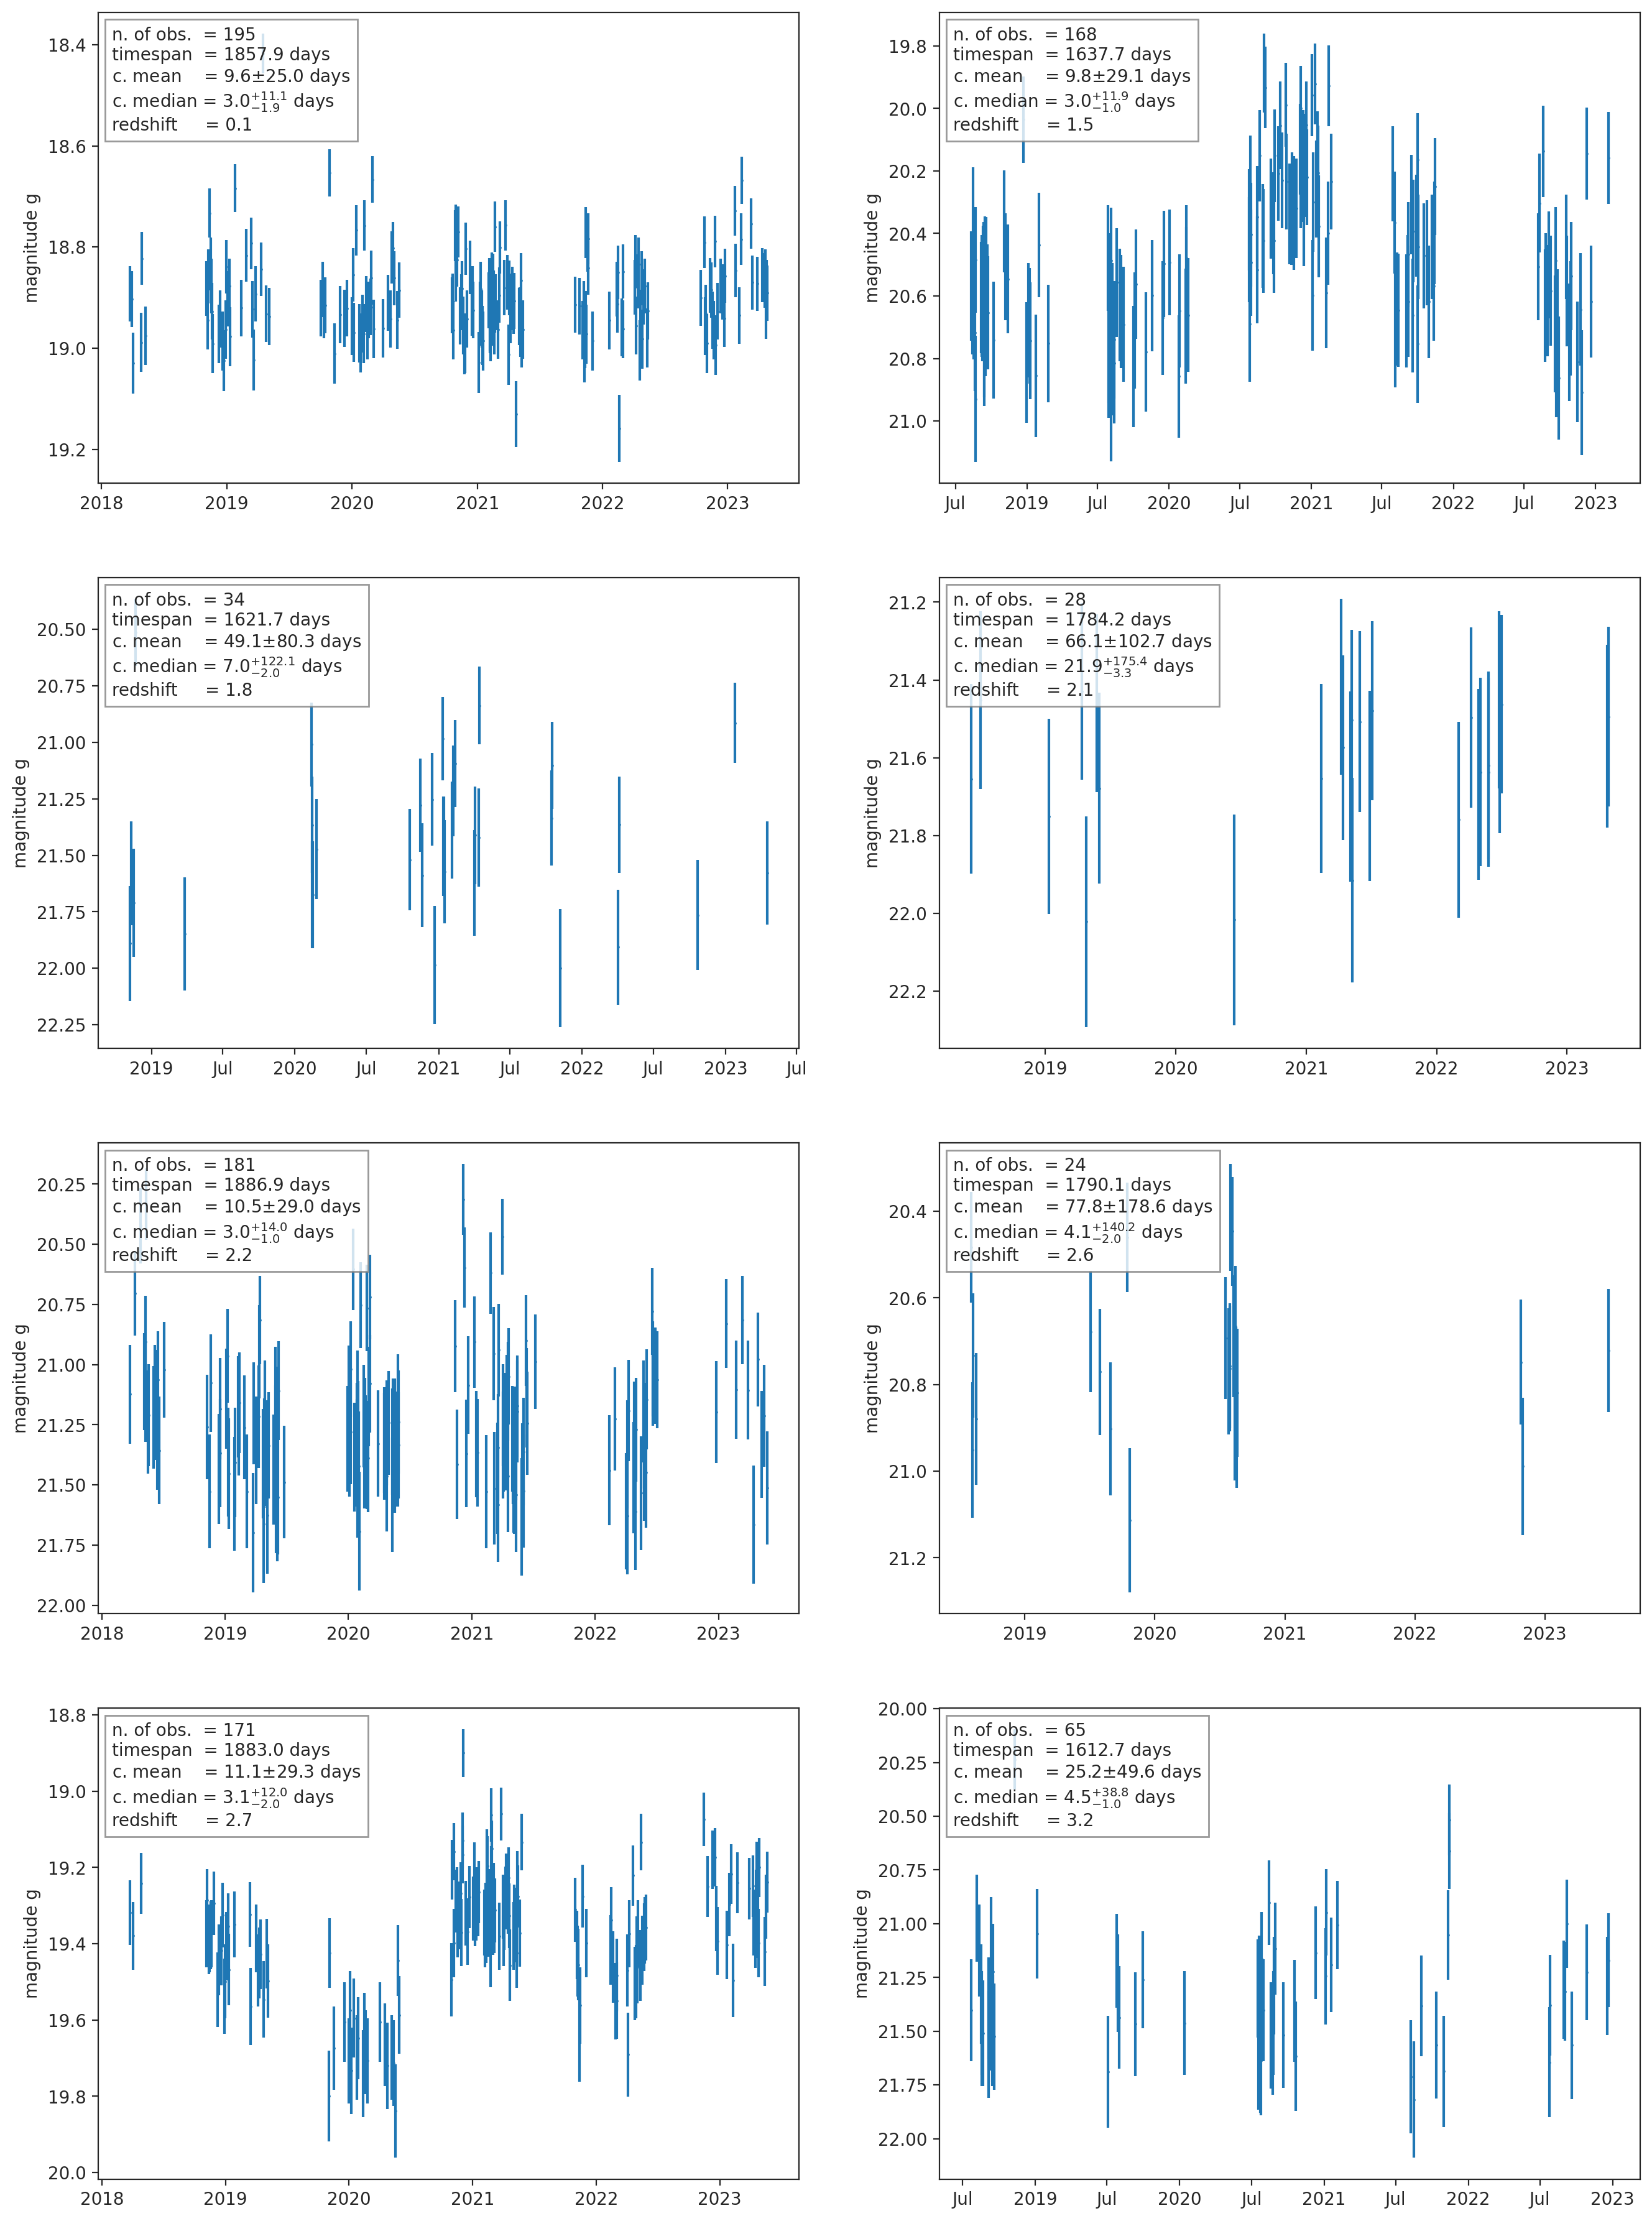

In [11]:
# Sample
idx_qso = sdss_x_ztf['g']['CLASS'] == 'QSO'
idx_qso_sample = random.sample(list(np.where(idx_qso)[0]), 8)

# Sort by redshift
redshifts = sdss_x_ztf['g'].loc[idx_qso_sample, 'Z']
idx_qso_sample = [i for _, i in sorted(zip(redshifts, idx_qso_sample))]

# Plot lighcurves
size = 16
fig, axs = plt.subplots(4, 2, figsize=(size, size / 210 * 297))
axs = axs.flatten()
for i, ax in zip(idx_qso_sample, axs):
    plot_light_curve(ztf_x_sdss_lc['g'][i], ax)

    # Add statistics
    lc = ztf_x_sdss_features['g'].loc[i]
    info = [
        'n. of obs.  = {}'.format(lc['n_obs']),
        'timespan  = {:.1f} days'.format(lc['timespan']),
        'c. mean    = {:.1f}$\pm${:.1f} days'.format(lc['cadence_mean'], lc['cadence_std']),
        'c. median = ${:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$ days'.format(lc['cadence_median'], lc['cadence_plus_sigma'], lc['cadence_minus_sigma']),
        'redshift     = {:.1f}'.format(sdss_x_ztf['g'].loc[i, 'Z']),
    ]
    info = '\n'.join(info)
    text_plot = plt.text(.02, .97, info, ha='left', va='top', transform=ax.transAxes)
    text_plot.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='grey'))

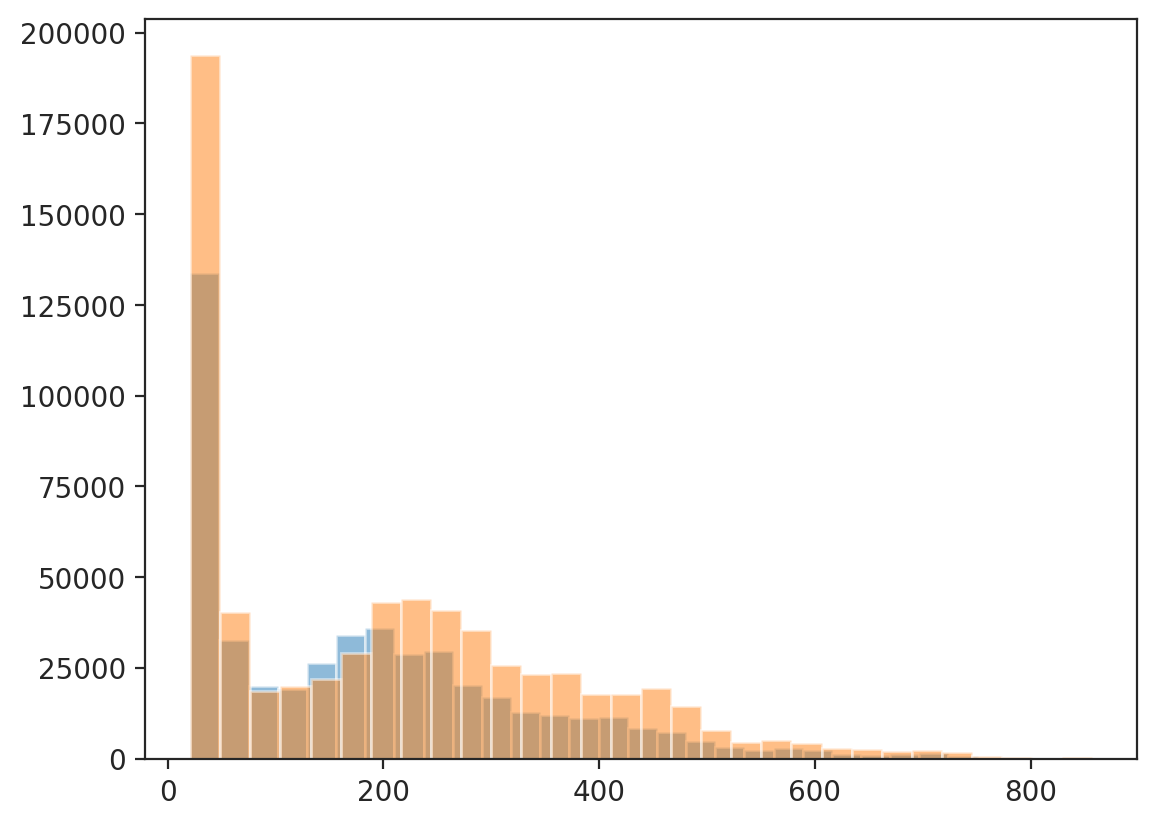

In [36]:
# Histogram of number of observations
# Important for retraining on all data not on available features subset
for filter in ['g', 'r']:
    plt.hist(ztf_x_sdss_features[filter]['n_obs'], bins=30, alpha=0.5)

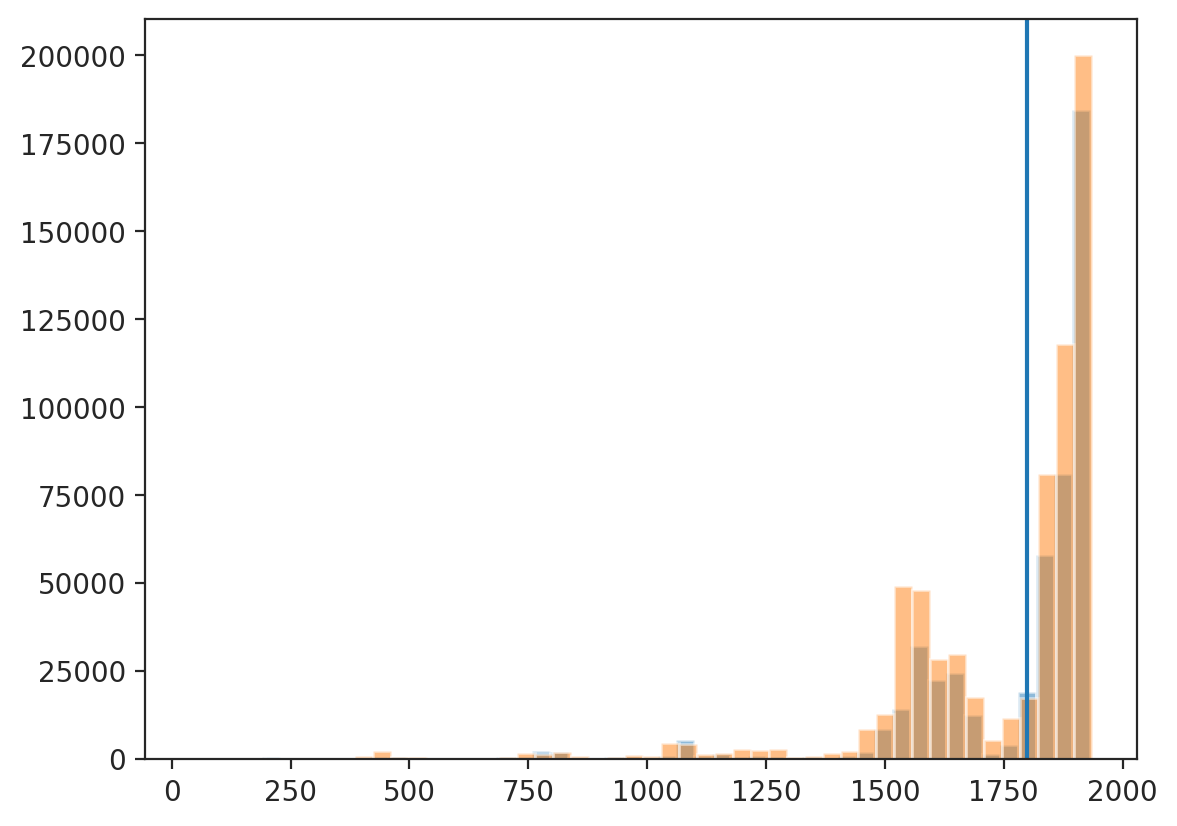

In [63]:
# Histogram of timespan
for filter in ['g', 'r']:
    plt.hist(ztf_x_sdss_features[filter]['timespan'], bins=50, alpha=0.5)
plt.axvline(1800)

In [64]:
ztf_x_sdss_features[filter]['timespan'].shape

(664676,)

In [65]:
(ztf_x_sdss_features[filter]['timespan'] > 1800).sum()

412787